In [16]:
%matplotlib inline

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [14]:
warnings.filterwarnings(action='ignore')

Generate random function with periodic frequencies and plot it

In [4]:
np.random.seed(0)

In [5]:
freqs = np.random.random(size=4)
amplitudes = 0.1 + 0.9*np.random.random(size=4)

In [261]:
N = 1000
t = np.linspace(0, 10, N)
noise = np.random.normal(0, 0.5, size=N)
y = np.sum([a * np.cos(2*np.pi*f*t) for a,f in zip(amplitudes, freqs)], axis=0)

Select a random subsample of the points to do inference and plot them.

In [262]:
idx = np.unique(sorted(np.random.randint(0, N, size=100)))
x = t[idx]
obs= y[idx] + noise[idx]

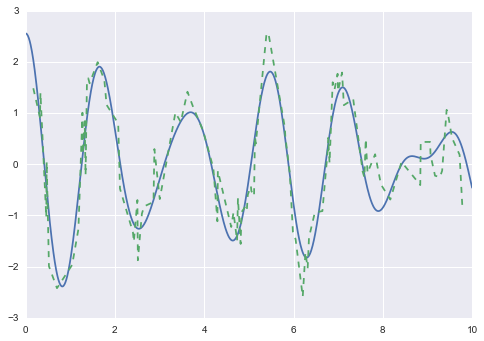

In [263]:
f = plt.plot(t, y, x, obs, '--')

### Inference 

Assume we know the kernel parameters. If they are not know, see the end of the notebook

In [273]:
sigma_sq = 1
scale_sq = 0.1
sigmay_sq = 0.04

In [274]:
def cov(a, b):
    return sigma_sq*np.exp(-((a[:, np.newaxis] - b[np.newaxis, :])**2)/(2*scale_sq))

Compute the covariance matrix of the observed points. In order to not overfit, we need to manually add a noise penalty to the covariance in form of diagonal matrix. Otherwise, we force the GP to go through theobserved points, which is something that we don't normally don't want.

Also, the scale parameters for the covariance matrixes should be large enough so the prior doesn't take effect. i.e. if the kernel doesn't take into account sufficiently far away points, the GP will give you the prior mean as the prediction (in this case 0)

Here we assume we don't have any numeric instabilities, but if we do, you need to compute the inverse in another way (or don't compute it at all)

In [281]:
Kxx = cov(x, x) + sigmay_sq * np.eye(len(x))
iKxx = np.linalg.inv(Kxx)

In [282]:
# assume we have to predict on all points. just as an example

In [277]:
Ktt = cov(t, t) + sigmay_sq * np.eye(len(t))
Ktx = cov(t, x)

In [278]:
mu = np.dot(Ktx, np.dot(iKxx, obs))
K = Ktt - np.dot(Ktx, np.dot(iKxx, Ktx.T))

In [279]:
# generate some samples
samples = np.random.multivariate_normal(mu, K, size=200)

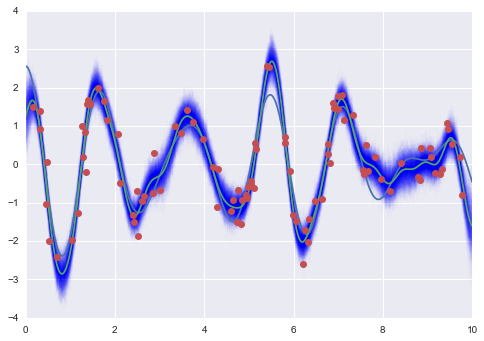

In [280]:
for sample in samples:
    plt.plot(t, sample, alpha=0.01, color='b')
f = plt.plot(t, y, t, mu, x, obs, 'o')

It is possible to find the hyperparameters of the kernels by marginalizing the likelihood over all possible functions
$$ p(y|X)  = \int p(y|f, X) p(f|X) df $$
it can be proven that this corresponds to:
$$ \log p(y|X) = \mathcal{N}(y|0,K_y) = -\frac{1}{2}yK_y^{-1}y-\frac{1}{2}\log|K_y|+ct.$$
We can express the matrix $K_y$ as a function of the parameters, compute the gradient and find it's maximum by any method we want. This equality happens because everything in the integral is gaussian, so when we integrate w.r.t some of the parameters the result is still gaussian.